# HomeWork: Classification

## Imports:

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler
from sklearn.preprocessing import RobustScaler, OneHotEncoder, QuantileTransformer, PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = 10, 10
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## About DataSet

In [3]:
# Loading the dataset
data = pd.read_csv('data/dataset_57_hypothyroid.csv', na_values='?')
data.head()
data.shape

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,f,f,f,f,f,f,f,f,...,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,...,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,...,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,...,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,...,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative


(3772, 30)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   object 
 3   query_on_thyroxine         3772 non-null   object 
 4   on_antithyroid_medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid_surgery            3772 non-null   object 
 8   I131_treatment             3772 non-null   object 
 9   query_hypothyroid          3772 non-null   object 
 10  query_hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

In [5]:
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/44 [00:00<?, ?it/s]

AttributeError: 'PandasArray' object has no attribute '_str_len'

In [9]:
data['TBG_measured'].unique()

array(['f'], dtype=object)

This feature has only one unique value, so it will not be important to us.

*Ratio of non-missing values in every column:*

age                          0.999735
sex                          0.960233
on_thyroxine                 1.000000
query_on_thyroxine           1.000000
on_antithyroid_medication    1.000000
sick                         1.000000
pregnant                     1.000000
thyroid_surgery              1.000000
I131_treatment               1.000000
query_hypothyroid            1.000000
query_hyperthyroid           1.000000
lithium                      1.000000
goitre                       1.000000
tumor                        1.000000
hypopituitary                1.000000
psych                        1.000000
TSH_measured                 1.000000
TSH                          0.902174
T3_measured                  1.000000
T3                           0.796129
TT4_measured                 1.000000
TT4                          0.938759
T4U_measured                 1.000000
T4U                          0.897402
FTI_measured                 1.000000
FTI                          0.897932
TBG_measured

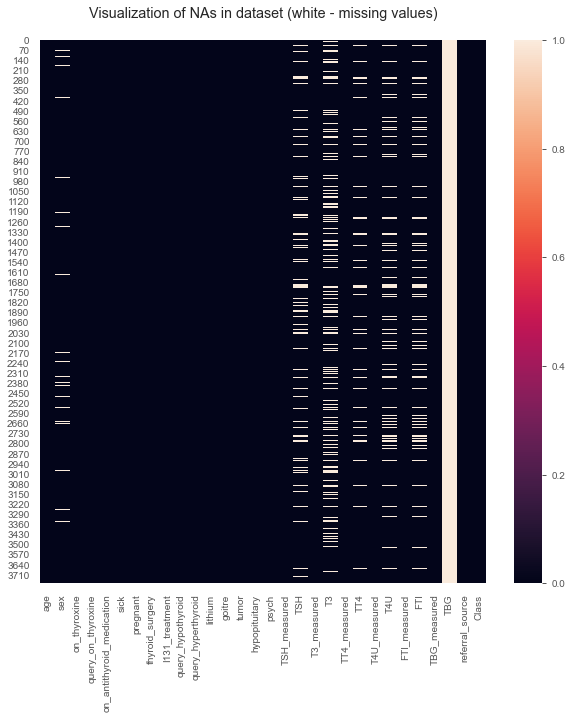

In [11]:
sns.heatmap(data.isna());
plt.title('Visualization of NAs in dataset (white - missing values)\n');

Here we can see feature `TBG` consists only Na values. So, it will not be important to us, too.

## Data preparation

Removing unnecessary columns

In [12]:
data.drop(['TBG_measured','TBG'], axis = 1, inplace = True)

Also we have outlier in `age` column

In [13]:
data.drop(data[data['age'] == 455.0].index, axis = 0, inplace = True)

And drop duplicate rows

In [15]:
duplicate_data = data[data.duplicated(keep="last")]
duplicate_data.shape

(61, 28)

In [16]:
data = data.drop_duplicates()
data.shape

(3710, 28)

In [17]:
TARGET = 'Class'

In [18]:
CATEGORICAL = ['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication',
               'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid',
               'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
               'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured',
               'FTI_measured', 'referral_source']
NUMERICAL = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

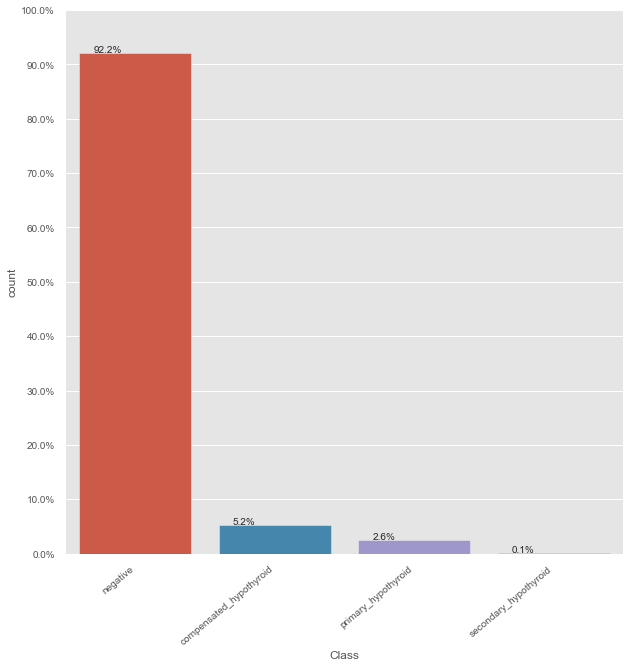

In [19]:
Y = data[TARGET]
total = len(Y)*1.
ax = sns.countplot(x=Y, data=data) #used to Show the counts of observations in each categorical bin using bars.
for p in ax.patches:
  ax.annotate('{:.1f}%'.format(100*p.get_height()/total), 
              (p.get_x()+0.1, p.get_height()+5))
#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))
#adjust the ticklabel to the desired format, without changing the position of the ticks.
ax.set_yticklabels(map('{:.1f}%'.format,
                       100*ax.yaxis.get_majorticklocs()/total))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show();

In [ ]:
data[TARGET].value_counts()

negative                   3419
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

*So, how we can see classes are very unbalanced. Of course, this will NOT positively affect the quality of classification.*
* I think we can choose Cross-validation because it is simple and used on a limited data sample.
* Target has 4 classes. That is why we will make Multiclass classification.
* Metrics which will be helpful for us: Precision,	Recall, f1-score and micro-metrics.

### Categorical features analysis

C:\Users\user\miniconda3\envs\course\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


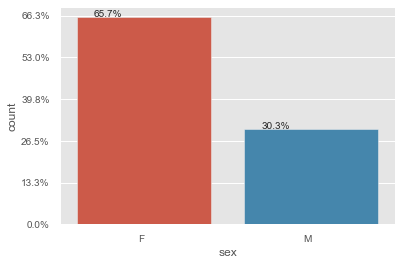

In [ ]:
Y = data['sex']
total = len(Y)*1.
ax = sns.countplot(x=Y, data=data) #used to Show the counts of observations in each categorical bin using bars.
for p in ax.patches:
  ax.annotate('{:.1f}%'.format(100*p.get_height()/total), 
              (p.get_x()+0.1, p.get_height()+5))

#adjust the ticklabel to the desired format, without changing the position of the ticks.
ax.set_yticklabels(map('{:.1f}%'.format,
                       100*ax.yaxis.get_majorticklocs()/total))
ax.set_xticklabels(ax.get_xticklabels(), ha="right")
plt.show();

### Numerical features analysis

C:\Users\user\miniconda3\envs\course\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\user\miniconda3\envs\course\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


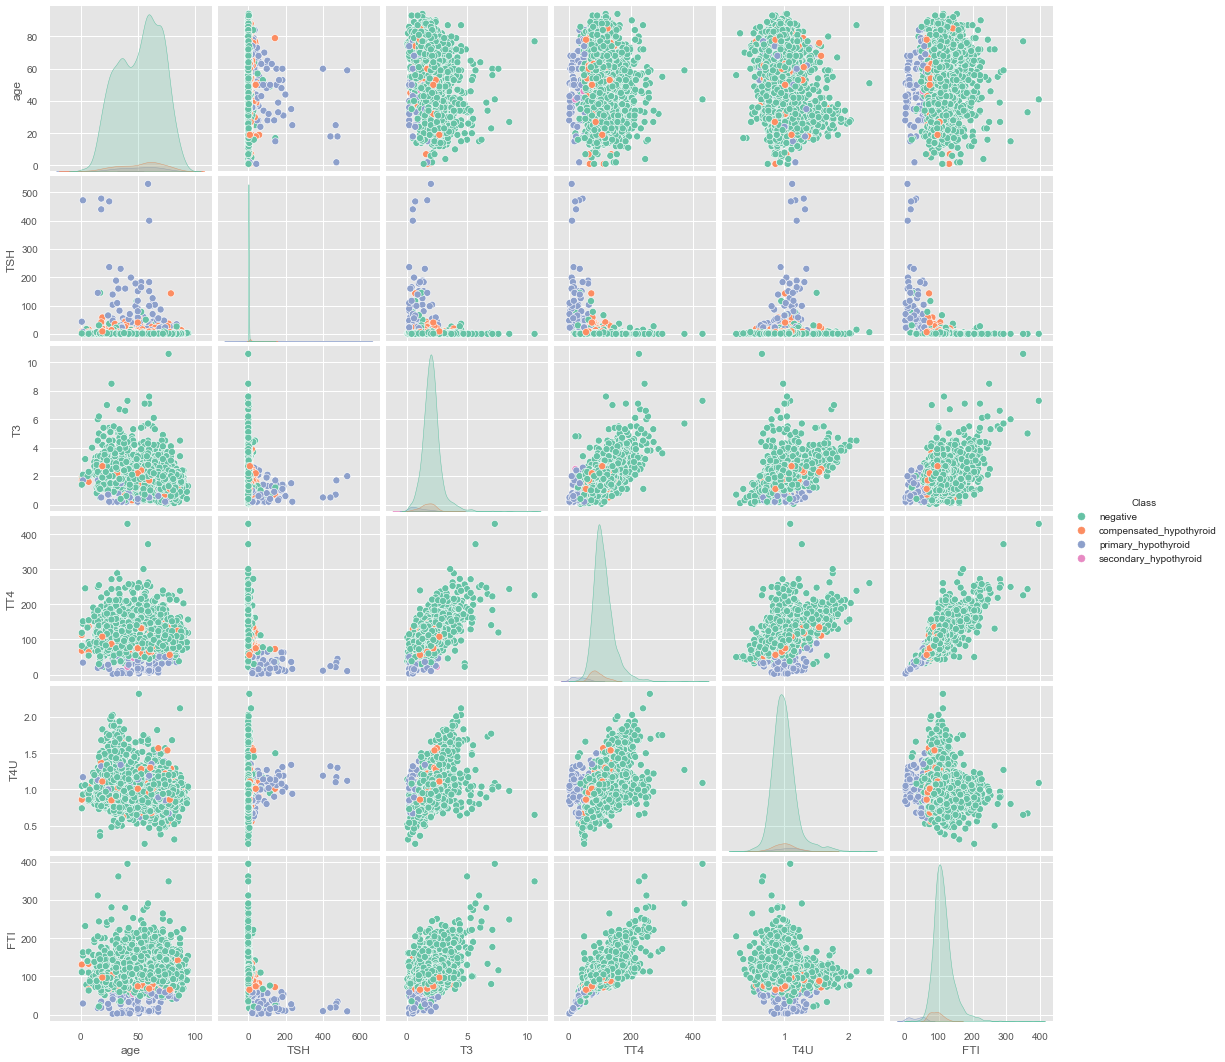

In [ ]:
# left
sns.pairplot(data, kind="scatter", hue=TARGET, palette="Set2")
plt.show();

* We see, that some of variables distributions are skewed, so to fill NAs with medians would be the best strategy.
* Also we see that feature `TSH` has some outliers, but I have not got a good description of this DataSet. Maybe replece them with median will be beter.

In [ ]:
def groups(x, y):
    sns.lmplot( x=x, y=y, data=data, fit_reg=False, hue='Class', legend=False)
    plt.legend(loc='best')
    plt.show();

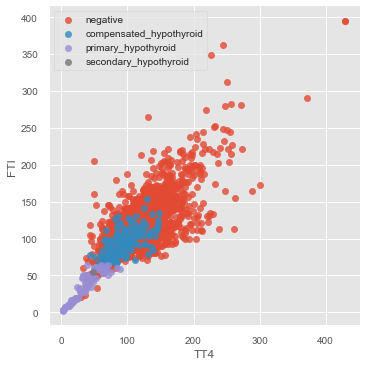

In [ ]:
groups("TT4", "FTI")

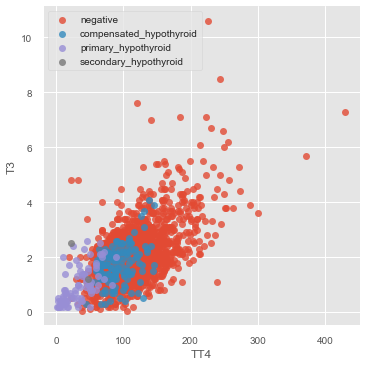

In [ ]:
groups("TT4", "T3")

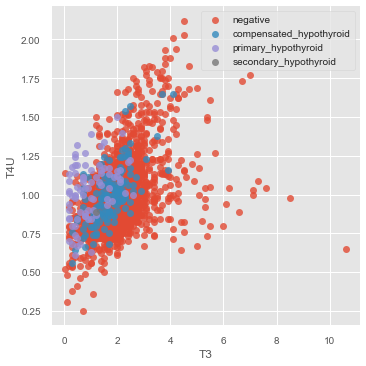

In [ ]:
groups("T3", "T4U")

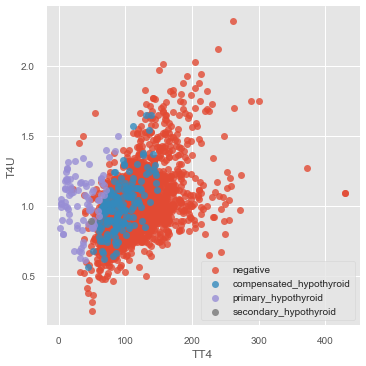

In [ ]:
groups("TT4", "T4U")

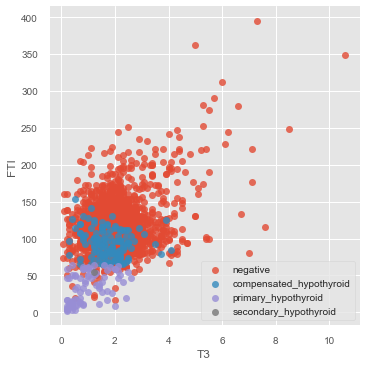

In [ ]:
groups("T3", "FTI")

In [ ]:
%matplotlib inline
def boxplots(label):
    sns.boxplot(data=data, x=TARGET, y=label)
    plt.show()

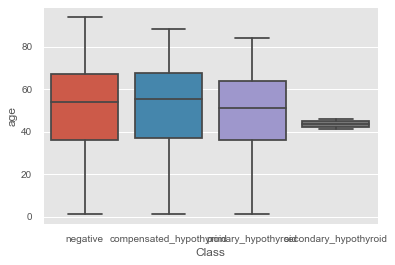

In [ ]:
boxplots('age')

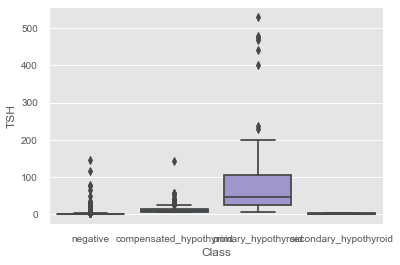

In [ ]:
boxplots('TSH')

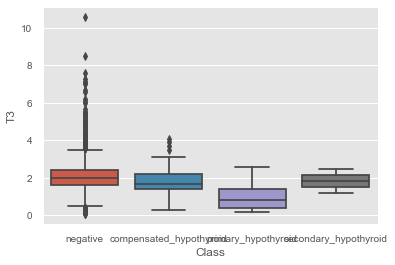

In [ ]:
boxplots('T3')

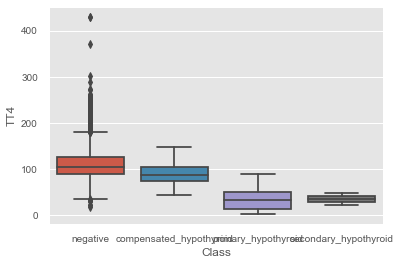

In [ ]:
boxplots('TT4')

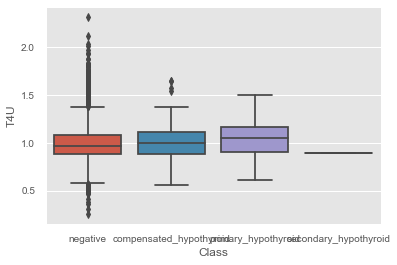

In [ ]:
boxplots('T4U')

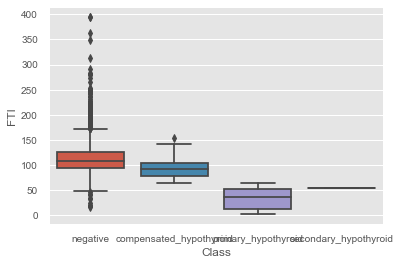

In [ ]:
boxplots('FTI')

In [ ]:
%matplotlib inline
def boxplotss(label):
    sns.boxplot(data=data, x=data['referral_source'], y=label)
    plt.show()

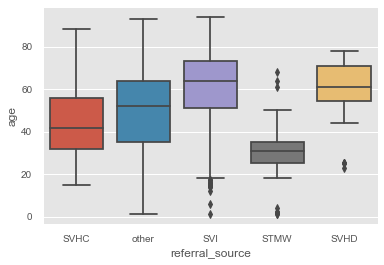

In [ ]:
boxplotss('age')

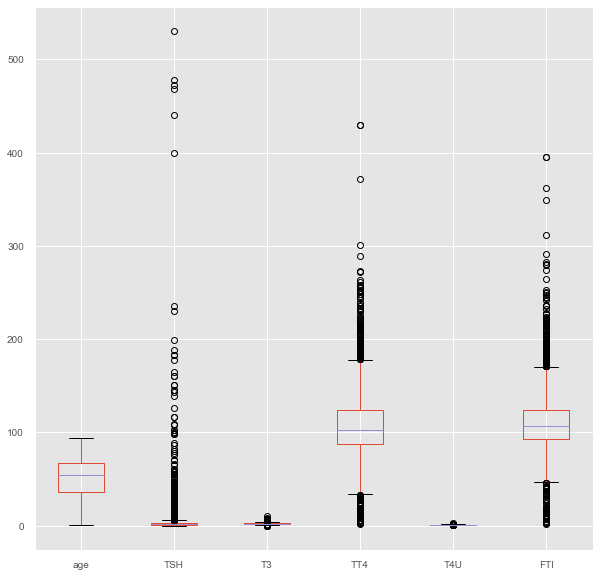

In [ ]:
data.boxplot();

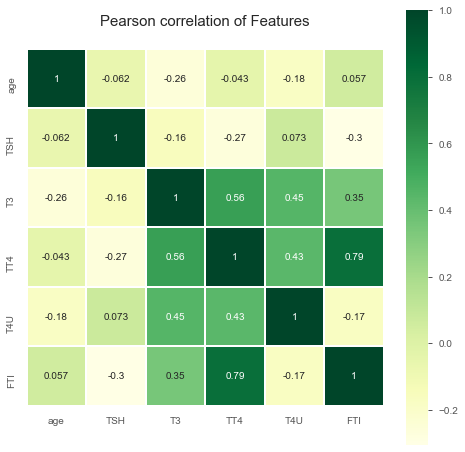

In [ ]:
%matplotlib inline
corr = data.corr()

f, ax = plt.subplots(figsize=(8,8))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(corr, cmap="YlGn", square=True, ax=ax, annot=True, linewidth=0.1)

plt.title("Pearson correlation of Features", y=1.05, size=15)
plt.show();

Here are just two features that are highly correlated with each other.

### Statistical Summary

In [ ]:
data.describe()

,age,TSH,T3,TT4,T4U,FTI
count,3709.000000,3401.000000,3001.000000,3539.000000,3383.000000,3385.000000
mean,51.751685,5.088993,2.013509,108.325742,0.994949,110.482629
std,19.005949,24.528509,0.827710,35.609792,0.195500,33.093017
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000
max,94.000000,530.000000,10.600000,430.000000,2.320000,395.000000


We can see that the numerical values do not have the same scale. We will need to apply scaling to the test set that we computed for the training set.

## Train/Test split

In [ ]:
target = data[TARGET].values

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(target)
encoded_target = encoder.transform(target)

LabelEncoder()

* 1 - negative
* 0 - compensated_hypothyroid
* 2 - primary_hypothyroid
* 3 - secondary_hypothyroid 

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(data.drop(TARGET, axis=1), encoded_target, 
                                                  random_state=21, shuffle=True, test_size = 0.2)

## Pipeline

### Numerical features

In [ ]:
num_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scale', MinMaxScaler()),
    ('transform', QuantileTransformer(output_distribution='normal'))
])

In [ ]:
num_features_transformed = num_features_pipeline.fit_transform(train_X[NUMERICAL], train_y)

In [ ]:
num_features_transformed.shape

(2968, 6)

### Categorical features

In [ ]:
cat_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [ ]:
cat_features_transformed = cat_features_pipeline.fit_transform(train_X[CATEGORICAL], train_y)

In [ ]:
cat_features_transformed.shape

(2968, 46)

### Unified pipeline

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_features_pipeline, NUMERICAL),
        ('cat', cat_features_pipeline, CATEGORICAL)
    ]
)

In [ ]:
unified_pipeline = Pipeline(
    steps=[
        ('preprocessing', preprocessor)
    ]
)

In [ ]:
all_features_transformed = unified_pipeline.fit_transform(train_X, train_y)

In [ ]:
all_features_transformed.shape

(2968, 52)

## CV split

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

## Baseline Logistic Regression

In [ ]:
def CV(model, X, y, cv):
    fitted = model.fit(X,y)
    CV_score = np.mean(cross_val_score(estimator = fitted, X = X, y = y, cv = cv))
    print('Mean CV score for 5 folds = {}'.format(CV_score))

In [ ]:
LogisticRegression_pipeline = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classify', LogisticRegression())
    ]
)

In [ ]:
model = LogisticRegression_pipeline.fit(train_X, train_y) #one vs all
print('======Multiclass prediction:======')
predictions = model.predict(train_X)
predictions_proba = model.predict_proba(train_X)
predictions_proba[:5]

======Multiclass prediction:======


array([[2.65331792e-06, 9.99996862e-01, 2.49749023e-10, 4.84158603e-07],
       [2.91825804e-06, 9.99996432e-01, 1.90578995e-08, 6.31030873e-07],
       [2.23741755e-07, 9.99999770e-01, 3.40891175e-13, 6.44660859e-09],
       [1.86809492e-04, 9.99806616e-01, 2.20775851e-07, 6.35351706e-06],
       [2.12640432e-07, 9.99999688e-01, 5.97687617e-11, 9.90805583e-08]])

In [ ]:
CV(LogisticRegression_pipeline, train_X, train_y, cv)

Mean CV score for 5 folds = 0.9784369836646396


In [ ]:
# creating a confusion matrix
LR_predictions = model.predict(val_X) 
conf = confusion_matrix(val_y, LR_predictions)

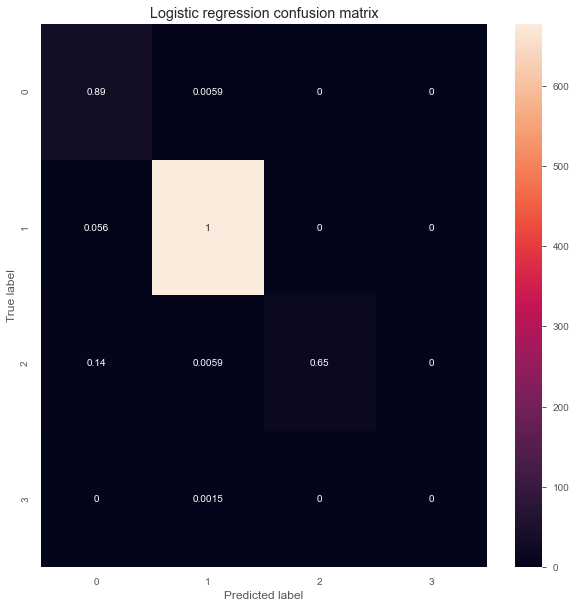

In [ ]:
sns.heatmap(conf,
            annot=conf/np.sum(conf,axis=1), #normalized by true class sizes
           );
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

* *precision* - rакой процент ваших прогнозов оказался верным?
* *recall* - какой процент положительных случаев вы выявили?
* *f1-score* - rакой процент положительных прогнозов оказался верным? 

In [ ]:
print(classification_report(train_y, predictions))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       158
           1       0.99      1.00      0.99      2740
           2       0.91      0.93      0.92        69
           3       0.00      0.00      0.00         1

    accuracy                           0.99      2968
   macro avg       0.71      0.70      0.70      2968
weighted avg       0.99      0.99      0.99      2968



So, from this report we can see that Logistic Regression works better then KNN-classifier. But also we need to deal with class imbalances.

### GridSearch

In [ ]:
param_grid = [
    {
        'preprocessing__num__impute': [
            SimpleImputer(missing_values=np.nan, strategy='mean'),
            SimpleImputer(missing_values=np.nan, strategy='median'),
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ],
        'preprocessing__num__scale': [
            MinMaxScaler(),
            MaxAbsScaler(),
            RobustScaler(),
            StandardScaler()
        ],
        'preprocessing__num__transform': [
            QuantileTransformer(output_distribution='normal'),
            PowerTransformer()
        ]
    }
]

In [ ]:
grid = GridSearchCV(LogisticRegression_pipeline, cv=5, param_grid=param_grid)

In [ ]:
grid.fit(train_X, train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          MinMaxScaler()),
                                                                                         ('transform',
                                                                                          QuantileTransformer(output_distribution='normal'))]),
                                                                         ['age',
                                                                          'TSH',
                     

In [ ]:
predictions = grid.best_estimator_.predict(train_X)
y_pred = grid.best_estimator_.predict_proba(val_X)
y_pred[:5]

array([[1.12676770e-07, 9.99999081e-01, 3.83585506e-09, 8.02775660e-07],
       [9.68973293e-04, 9.99028284e-01, 3.14370545e-08, 2.71114390e-06],
       [5.15331561e-04, 9.99379102e-01, 7.26727955e-05, 3.28934616e-05],
       [4.87865238e-11, 9.99999999e-01, 5.49811626e-14, 5.92431618e-10],
       [4.45046277e-08, 9.99999950e-01, 1.93487014e-13, 5.22900574e-09]])

In [ ]:
grid_predictions = grid.predict(val_X) 
conf = confusion_matrix(val_y, grid_predictions)

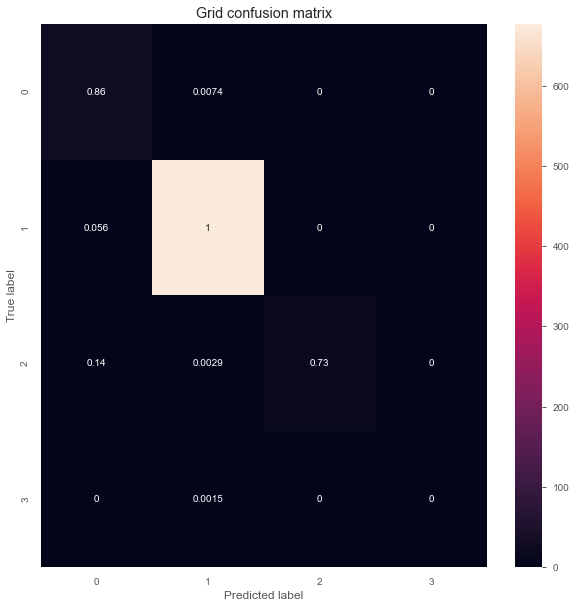

In [ ]:
sns.heatmap(conf,
            annot=conf/np.sum(conf,axis=1), #normalized by true class sizes
           );
plt.title('Grid confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

In [ ]:
print(classification_report(train_y, predictions))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       158
           1       0.99      1.00      0.99      2740
           2       0.92      0.88      0.90        69
           3       0.00      0.00      0.00         1

    accuracy                           0.99      2968
   macro avg       0.71      0.69      0.70      2968
weighted avg       0.99      0.99      0.99      2968



A little better, but still not enough

### SMOTE

In [ ]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)],
                                ['classifier', LogisticRegression(random_state=21,
                                                                  max_iter=1000)]])

stratified_kfold = KFold(n_splits=5, shuffle=True, random_state=21)
    
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(train_X, train_y)
cv_score = grid_search.best_score_
test_score = grid_search.score(val_X, val_y)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

ValueError: could not convert string to float: 'M'

#  KNN classification

In [ ]:
# knn_classifier_pipeline = Pipeline(
#     steps=[
#         ('preprocessing', preprocessor),
#         ('classify', KNeighborsClassifier())
#     ]
# )

In [ ]:
# knn = knn_classifier_pipeline.fit(train_X, train_y)

In [ ]:
# predictions = knn.predict(train_X)
# predictions

In [ ]:
# predictions_proba = knn.predict_proba(train_X)
# predictions_proba[:15]

In [ ]:
# # creating a confusion matrix
# knn_predictions = knn.predict(val_X) 
# cm = confusion_matrix(val_y, knn_predictions)

In [ ]:
# sns.heatmap(cm,
#             annot=cm/np.sum(cm,axis=1), #normalized by true class sizes
#            );
# plt.title('KNN regression confusion matrix');
# plt.xlabel('Predicted label');
# plt.ylabel('True label');

* *precision* - rакой процент ваших прогнозов оказался верным?
* *recall* - какой процент положительных случаев вы выявили?
* *f1-score* - rакой процент положительных прогнозов оказался верным? 

In [ ]:
# print(classification_report(train_y, predictions))

So, from this report we can see that this classification does not work very well due to the imbalance of the classes. The last class with the least number of values is impossible to predict.Classification works best on the class with the most values. Therefore, we need to deal with class imbalances.